In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
data_path = "/Users/yhra/Documents/Master/Semester_3/MLFMM/UE/09/Files_09"


# Intro to Autodiff

## 1.1 Simple example

In [3]:
x = torch.tensor(2.0, requires_grad=True)
y = 2/((5.0 - x)**2 + 2**2)
y.backward()
print(f"The derivative of f(x) at x = 2.0 is: {np.round(x.grad.item(), 3)}")

The derivative of f(x) at x = 2.0 is: 0.071


## 1.2 Compute sigmoid activation function

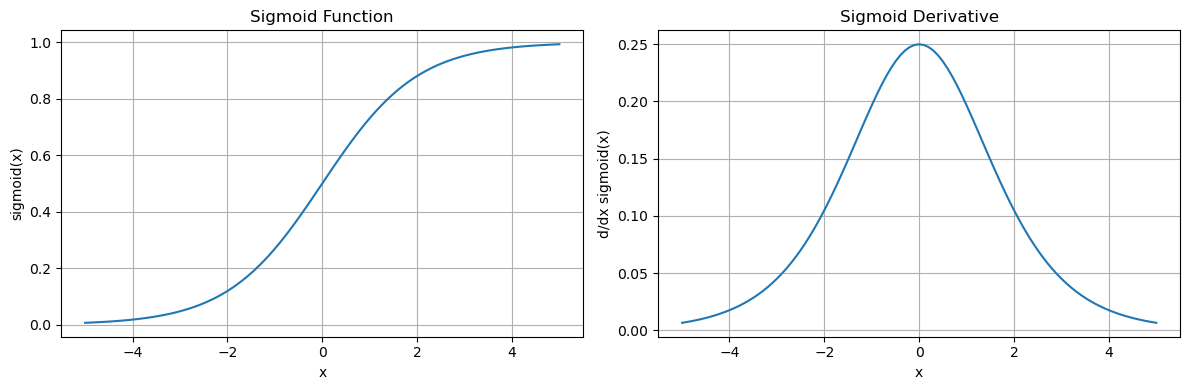

In [4]:
# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Create input tensor
x = torch.arange(-5.0, 5.1, 0.1, requires_grad=True)

# Compute sigmoid
y = sigmoid(x)

# Compute derivative - need to sum y to get scalar for backward()
y.sum().backward()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot sigmoid function
ax1.plot(x.detach().numpy(), y.detach().numpy())
ax1.set_title('Sigmoid Function')
ax1.set_xlabel('x')
ax1.set_ylabel('sigmoid(x)')
ax1.grid(True)

# Plot derivative 
ax2.plot(x.detach().numpy(), x.grad.numpy())
ax2.set_title('Sigmoid Derivative')
ax2.set_xlabel('x')
ax2.set_ylabel('d/dx sigmoid(x)')
ax2.grid(True)

plt.tight_layout()
plt.show()


## 1.3 Compute gradients of a vector-valued function

In [27]:
# Create input tensors
x = torch.tensor(1.376, requires_grad=True)
y = torch.tensor(2.123, requires_grad=True)

# Define vector-valued function f(x,y) = [x^2 + y^2, 2x^2*y^2]
f = torch.stack([x**2 + y**2, 2 * x**2 * y**2])

# Calculate gradients for first component f1
f[0].backward(retain_graph=True)
df1_dx = x.grad.item()
df1_dy = y.grad.item()

# Zero out gradients before calculating second component
x.grad.zero_()
y.grad.zero_()

# Calculate gradients for second component f2 
f[1].backward()
df2_dx = x.grad.item()
df2_dy = y.grad.item()

# Print gradients rounded to 3 digits
print(f"∂f1/∂x = {np.round(df1_dx, 3)}")
print(f"∂f2/∂y = {np.round(df2_dy, 3)}")

∂f1/∂x = 2.752
∂f2/∂y = 16.079


## 1.4 Compute Gradients of Matrix-valued function


In [6]:
# Create tensor A
A = torch.tensor([[1., 2.], [3., 4.]], requires_grad=True)

# Define function f(A) = trace(A^2)
# A^2 is matrix multiplication A @ A
# trace is sum of diagonal elements
f = (A @ A).diagonal().sum()

# Calculate gradient
f.backward()

# Print full gradient
print("Gradient of f with respect to A:")
print(A.grad)

# Print element [0,1] rounded to 3 digits
print(f"\nElement [0,1] of gradient: {A.grad[0,1]:.3f}")


Gradient of f with respect to A:
tensor([[2., 6.],
        [4., 8.]])

Element [0,1] of gradient: 6.000


## 1.5 Value, first derivative, second derivative of sigmoid function

In [7]:
# Create input tensor
x = torch.tensor(0.173, requires_grad=True)

# Calculate sigmoid function value
y = torch.sigmoid(x)

# Calculate first derivative using autograd.grad instead of backward()
y_prime = torch.autograd.grad(y, x, create_graph=True)[0]

# Calculate second derivative
y_double_prime = torch.autograd.grad(y_prime, x)[0]

# Print results rounded to 3 digits
print(f"First derivative f'(x=0.173) = {y_prime.item():.3f}")
print(f"Second derivative f''(x=0.173) = {y_double_prime.item():.3f}")

First derivative f'(x=0.173) = 0.248
Second derivative f''(x=0.173) = -0.021


# 2 Using AutoDiff for SGD

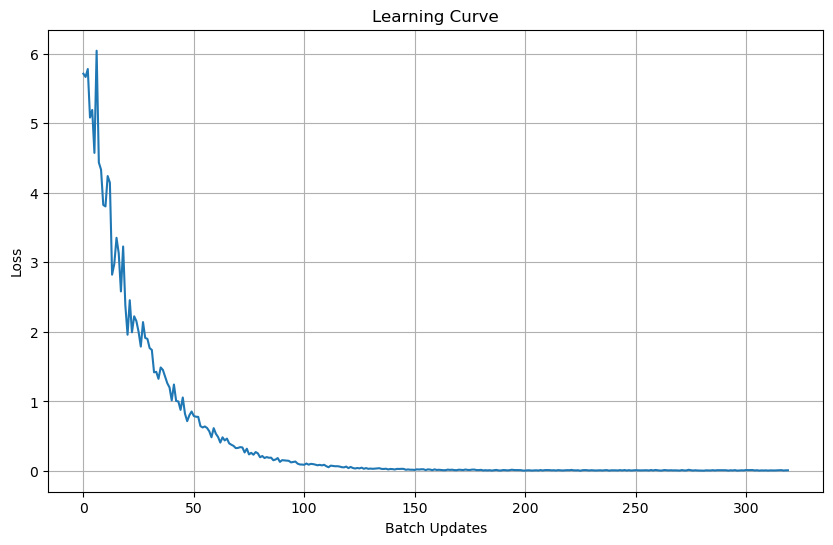


Final parameters:
Slope: 0.698
Bias: 2.296


In [8]:
from torch.utils.data import DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt

# Load data
X = torch.load(os.path.join(data_path, 'X.pt'))
y = torch.load(os.path.join(data_path, 'y.pt'))

# Create dataset and dataloader
dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize parameters (slope and bias) with zeros
parameters = torch.zeros(2, requires_grad=True)

# Define loss function
criterion = torch.nn.MSELoss()

# Set hyperparameters
num_epochs = 10
eta = 0.01

# List to store losses
batch_losses = []

# Training loop
for epoch in range(num_epochs):
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        # Zero the gradients
        if parameters.grad is not None:
            parameters.grad.zero_()
            
        # Forward pass - linear model: y = mx + b
        outputs = parameters[0] * inputs + parameters[1]
        loss = criterion(outputs, targets)
        
        # Store the loss
        batch_losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        with torch.no_grad():
            parameters.copy_(parameters - eta * parameters.grad)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(batch_losses)
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.grid(True)
plt.show()

# Print final parameters
print(f"\nFinal parameters:")
print(f"Slope: {parameters[0].item():.3f}")
print(f"Bias: {parameters[1].item():.3f}")


## Task 2.3 Use train, val, test split


Epoch with minimum training loss: 149

Epoch with minimum validation loss: 78


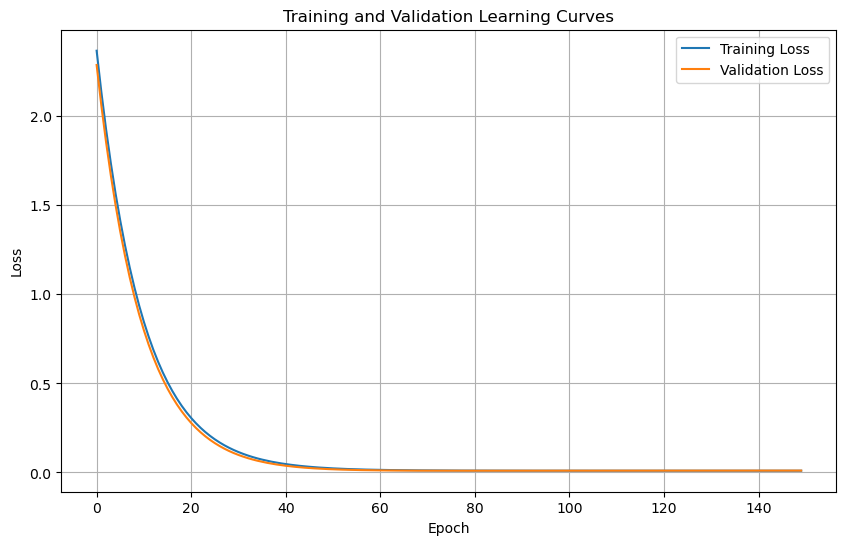

Final MSE: 0.010
MSE with parameters at minimum validation loss: 0.011
MSE with parameters at minimum training loss: 0.010
Relative improvement from final to minimum validation loss: -0.073
Relative improvement from final to minimum training loss: 0.000


In [20]:
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Split remaining 20% into validation and test (10% each of original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Training parameters
n_epochs = 150
eta = 0.001

# Initialize parameters
parameters = torch.randn(2, requires_grad=True)
criterion = torch.nn.MSELoss()

# Lists to store epoch losses
train_losses = []
val_losses = []

# list to store parameters at each epoch
parameters_list = []

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    # Training phase
    for inputs, targets in train_loader:
        # Zero gradients
        if parameters.grad is not None:
            parameters.grad.zero_()   
        # Forward pass of linear model y = mx + b
        outputs = parameters[0] * inputs + parameters[1]
        loss = criterion(outputs, targets)
        # Store batch loss
        batch_losses.append(loss.item())
        # Backward pass and update
        loss.backward()
        with torch.no_grad():
            parameters.copy_(parameters - eta * parameters.grad)
    
    # Compute full training set loss
    # We use torch.no_grad() here because:
    # 1. We're only evaluating/computing losses, not training
    # 2. We don't need to track gradients which saves memory and computation
    # 3. Disabling gradient tracking makes evaluation faster
    with torch.no_grad():
        train_loss = 0
        n_samples = 0
        for inputs, targets in train_loader:
            outputs = parameters[0] * inputs + parameters[1]
            train_loss += criterion(outputs, targets).item() * len(inputs)
            n_samples += len(inputs)
        train_loss /= n_samples
        train_losses.append(train_loss)
        
        # Compute validation loss

        val_loss = 0
        n_samples = 0
        for inputs, targets in val_loader:
            outputs = parameters[0] * inputs + parameters[1]
            val_loss += criterion(outputs, targets).item() * len(inputs)
            n_samples += len(inputs)
        val_loss /= n_samples
        val_losses.append(val_loss)

        # Store parameters at each epoch
        parameters_list.append(parameters.clone().detach())

# Find epochs with minimum losses
min_train_epoch = np.argmin(train_losses)
min_val_epoch = np.argmin(val_losses)

print(f"\nEpoch with minimum training loss: {min_train_epoch}")
print(f"\nEpoch with minimum validation loss: {min_val_epoch}")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

# Compute MSE on test Set with parameters after 150 epochs and the ones that
# gave the minimum validation loss

print(f"Final MSE: {train_losses[-1]:.3f}")
print(f"MSE with parameters at minimum validation loss: {train_losses[min_val_epoch]:.3f}")
print(f"MSE with parameters at minimum training loss: {train_losses[min_train_epoch]:.3f}")
print(f"Relative improvement from final to minimum validation loss: {(train_losses[-1] - train_losses[min_val_epoch]) / train_losses[-1]:.3f}")
print(f"Relative improvement from final to minimum training loss: {(train_losses[-1] - train_losses[min_train_epoch]) / train_losses[-1]:.3f}")


Training with momentum coefficient set: Set1
μ = 0.0
μ = 0.1
μ = 0.2
μ = 0.3

Training with momentum coefficient set: Set2
μ = 0.0
μ = 0.5
μ = 0.9
μ = 1.0

Training with momentum coefficient set: Set3
μ = 1.0
μ = 0.9
μ = 0.5
μ = 0.1

Training with momentum coefficient set: Set4
μ = 0.2
μ = 0.4
μ = 0.6
μ = 0.8

Training with momentum coefficient set: Set5
μ = 0
μ = 1
μ = 2
μ = 3

Training with momentum coefficient set: Set6
μ = -1
μ = 0
μ = 1
μ = 2


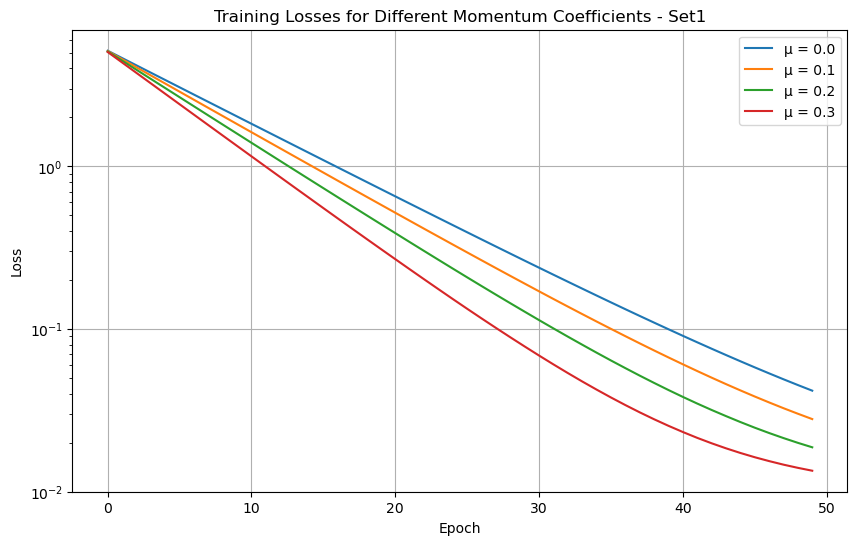

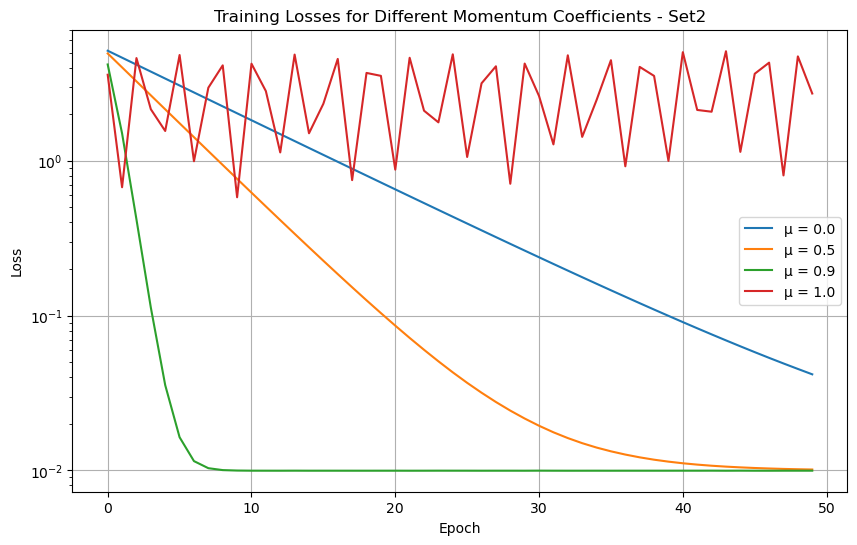

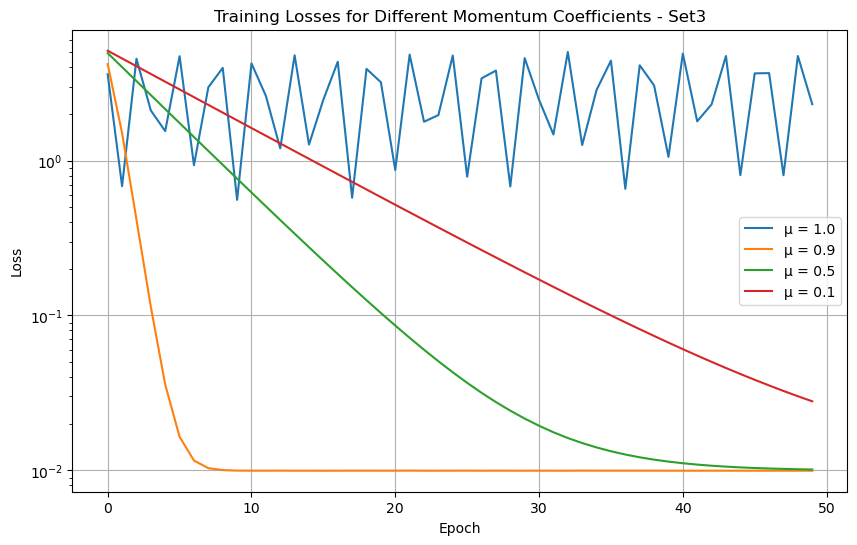

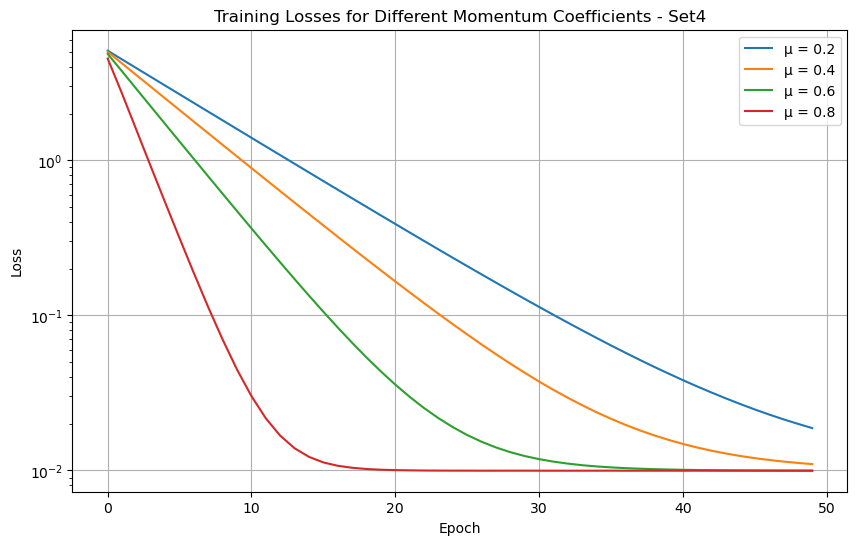

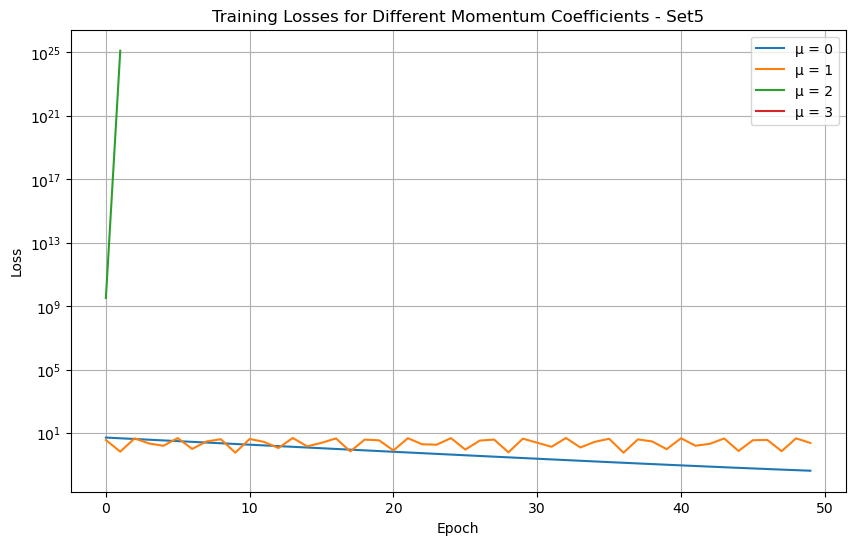

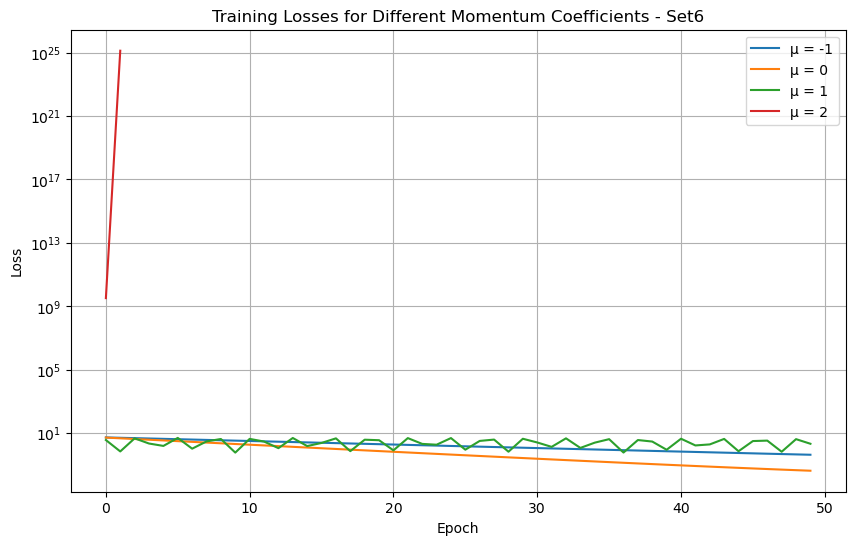

In [26]:
# Initialize learning rate gamma
gamma = 0.001  # Learning rate

# Different momentum coefficients to try
momentum_coefficients = {"Set1": [0.0, 0.1, 0.2, 0.3],
                        "Set2": [0.0, 0.5, 0.9, 1.0],
                        "Set3": [1.0, 0.9, 0.5, 0.1],
                        "Set4": [0.2, 0.4, 0.6, 0.8],
                        "Set5": [0, 1, 2, 3],
                        "Set6": [-1, 0, 1, 2]}

# Dictionary to store losses for each momentum coefficient
all_train_losses = {}

for Set, mu_list in momentum_coefficients.items():
    print(f"\nTraining with momentum coefficient set: {Set}")
    all_train_losses[Set] = {}  # Store losses for each mu in this set
    
    for mu in mu_list:
        print(f"μ = {mu}")
        # Initialize parameters and momentum buffer
        parameters = torch.tensor([1.0, 0.0], requires_grad=True)
        momentum_buffer = None

        # Lists to store losses and parameters
        train_losses = []

        # Training loop
        for epoch in range(50):
            # Training
            train_loss = 0
            n_samples = 0
            
            for inputs, targets in train_loader:
                # Zero gradients
                if parameters.grad is not None:
                    parameters.grad.zero_()
                
                # Forward pass and loss computation
                outputs = parameters[0] * inputs + parameters[1]
                loss = criterion(outputs, targets)
                
                # Backward pass
                loss.backward()
                
                # Compute gradient
                gradient = parameters.grad.clone()
                
                # Update momentum buffer
                if momentum_buffer is None:
                    momentum_buffer = gradient
                else:
                    momentum_buffer = mu * momentum_buffer + gradient
                
                # Update parameters using momentum
                with torch.no_grad():
                    parameters -= gamma * momentum_buffer
                
                train_loss += loss.item() * len(inputs)
                n_samples += len(inputs)
            
            train_loss /= n_samples
            train_losses.append(train_loss)
    
        all_train_losses[Set][mu] = train_losses

# Plot training losses for each set separately
for Set, mu_losses in all_train_losses.items():
    plt.figure(figsize=(10, 6))
    for mu, losses in mu_losses.items():
        plt.plot(losses, label=f'μ = {mu}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set logarithmic scale for y-axis
    plt.title(f'Training Losses for Different Momentum Coefficients - {Set}')
    plt.legend()
    plt.grid(True)
    plt.show()
